<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_VGG19_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 11:44:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   34C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6012510059990746
GPU (s):
0.03169349499876262
GPU speedup over CPU: 18x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.vgg16.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 19s 42ms/step - loss: 1.6803 - accuracy: 0.5723 - val_loss: 0.7422 - val_accuracy: 0.6858
Epoch 2/100
360/360 [==============================] - 16s 45ms/step - loss: 0.7856 - accuracy: 0.6718 - val_loss: 0.7001 - val_accuracy: 0.7048
Epoch 3/100
360/360 [==============================] - 14s 39ms/step - loss: 0.7215 - accuracy: 0.7000 - val_loss: 0.6650 - val_accuracy: 0.7174
Epoch 4/100
360/360 [==============================] - 14s 40ms/step - loss: 0.7010 - accuracy: 0.7120 - val_loss: 0.6428 - val_accuracy: 0.7303
Epoch 5/100
360/360 [==============================] - 14s 40ms/step - loss: 0.6718 - accuracy: 0.7198 - val_loss: 0.6364 - val_accuracy: 0.7358
Epoch 6/100
360/360 [==============================] - 15s 41ms/step - loss: 0.6557 - accuracy: 0.7282 - v

360/360 [==============================] - 14s 39ms/step - loss: 0.5027 - accuracy: 0.7979 - val_loss: 0.5387 - val_accuracy: 0.7840
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4978 - accuracy: 0.8008 - val_loss: 0.5600 - val_accuracy: 0.7819
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5011 - accuracy: 0.7984 - val_loss: 0.5385 - val_accuracy: 0.7890
Epoch 59/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4976 - accuracy: 0.8022 - val_loss: 0.5396 - val_accuracy: 0.7853
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4949 - accuracy: 0.8025 - val_loss: 0.5636 - val_accuracy: 0.7725
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4982 - accuracy: 0.8034 - val_loss: 0.5354 - val_accuracy: 0.7911
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4950 - accuracy: 0.8021 - val_loss: 0.5493 - val_accuracy

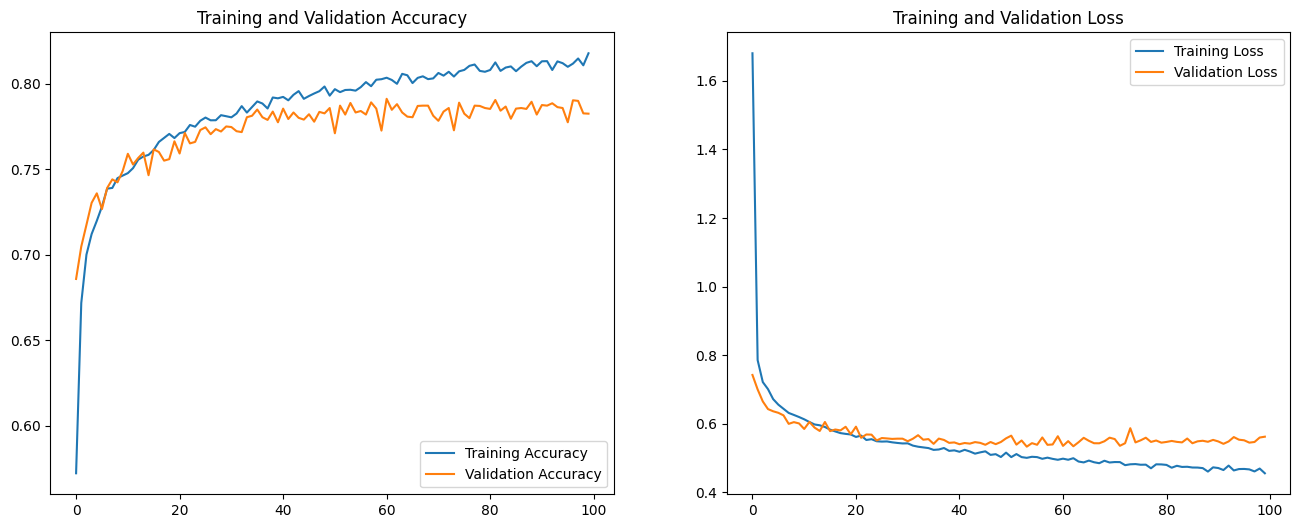

In [6]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 16s 37ms/step - loss: 2.1975 - accuracy: 0.5593 - val_loss: 0.8271 - val_accuracy: 0.6143
Epoch 2/100
360/360 [==============================] - 15s 42ms/step - loss: 0.8403 - accuracy: 0.6357 - val_loss: 0.7323 - val_accuracy: 0.6825
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7618 - accuracy: 0.6697 - val_loss: 0.6906 - val_accuracy: 0.6982
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7360 - accuracy: 0.6895 - val_loss: 0.6881 - val_accuracy: 0.6990
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.7108 - accuracy: 0.6965 - val_loss: 0.6821 - val_accuracy: 0.7143
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6944 - accuracy: 0.7052 - val_loss: 0.6779 - va

360/360 [==============================] - 14s 38ms/step - loss: 0.5379 - accuracy: 0.7771 - val_loss: 0.5917 - val_accuracy: 0.7629
Epoch 57/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5401 - accuracy: 0.7800 - val_loss: 0.5643 - val_accuracy: 0.7688
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5468 - accuracy: 0.7743 - val_loss: 0.5696 - val_accuracy: 0.7692
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5323 - accuracy: 0.7819 - val_loss: 0.5763 - val_accuracy: 0.7593
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5405 - accuracy: 0.7769 - val_loss: 0.5826 - val_accuracy: 0.7600
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5374 - accuracy: 0.7776 - val_loss: 0.5771 - val_accuracy: 0.7622
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5348 - accuracy: 0.7798 - val_loss: 0.5752 - val_accuracy

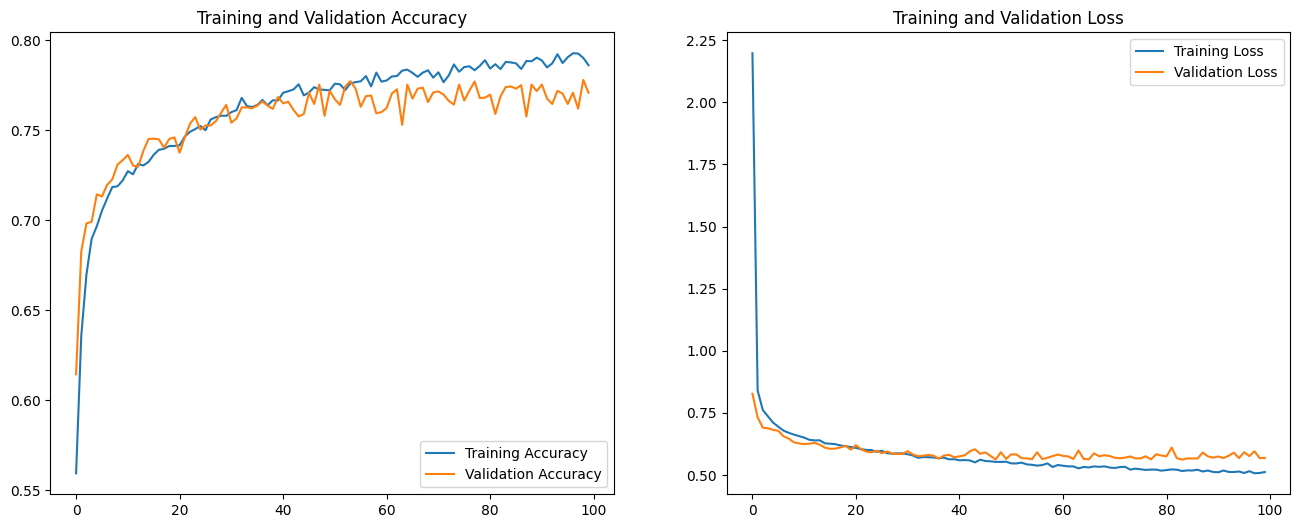

In [7]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 17s 39ms/step - loss: 0.9843 - accuracy: 0.6705 - val_loss: 0.5495 - val_accuracy: 0.7730
Epoch 2/100
360/360 [==============================] - 14s 39ms/step - loss: 0.6130 - accuracy: 0.7426 - val_loss: 0.5163 - val_accuracy: 0.7827
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5650 - accuracy: 0.7643 - val_loss: 0.4942 - val_accuracy: 0.8017
Epoch 4/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5395 - accuracy: 0.7765 - val_loss: 0.4708 - val_accuracy: 0.8086
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5163 - accuracy: 0.7881 - val_loss: 0.4628 - val_accuracy: 0.8116
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5054 - accuracy: 0.7913 - v

360/360 [==============================] - 14s 39ms/step - loss: 0.3765 - accuracy: 0.8526 - val_loss: 0.3698 - val_accuracy: 0.8505
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3767 - accuracy: 0.8488 - val_loss: 0.3915 - val_accuracy: 0.8494
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3731 - accuracy: 0.8529 - val_loss: 0.3863 - val_accuracy: 0.8494
Epoch 59/100
360/360 [==============================] - 14s 39ms/step - loss: 0.3695 - accuracy: 0.8520 - val_loss: 0.3577 - val_accuracy: 0.8602
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3815 - accuracy: 0.8503 - val_loss: 0.3646 - val_accuracy: 0.8578
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3676 - accuracy: 0.8541 - val_loss: 0.3665 - val_accuracy: 0.8571
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3680 - accuracy: 0.8549 - val_loss: 0.3722 - val_accuracy

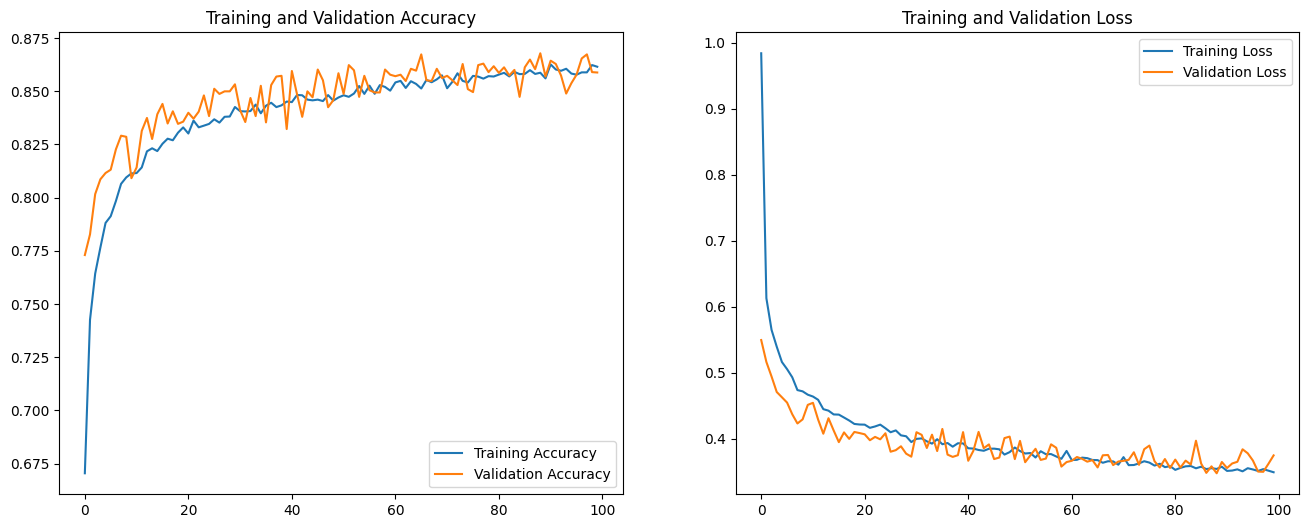

In [9]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 1.1710 - accuracy: 0.6723 - val_loss: 0.5422 - val_accuracy: 0.7704
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6012 - accuracy: 0.7536 - val_loss: 0.4828 - val_accuracy: 0.7965
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5475 - accuracy: 0.7780 - val_loss: 0.4699 - val_accuracy: 0.8029
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5242 - accuracy: 0.7853 - val_loss: 0.4552 - val_accuracy: 0.8110
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5012 - accuracy: 0.7933 - val_loss: 0.4609 - val_accuracy: 0.7965
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4909 - accuracy: 0.7987 - val_loss: 0.4254 - va

360/360 [==============================] - 13s 37ms/step - loss: 0.3750 - accuracy: 0.8504 - val_loss: 0.3603 - val_accuracy: 0.8578
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3730 - accuracy: 0.8507 - val_loss: 0.3592 - val_accuracy: 0.8550
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3704 - accuracy: 0.8503 - val_loss: 0.3696 - val_accuracy: 0.8526
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3701 - accuracy: 0.8508 - val_loss: 0.3773 - val_accuracy: 0.8498
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3680 - accuracy: 0.8508 - val_loss: 0.3578 - val_accuracy: 0.8522
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3702 - accuracy: 0.8514 - val_loss: 0.3708 - val_accuracy: 0.8499
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3705 - accuracy: 0.8532 - val_loss: 0.3631 - val_accuracy

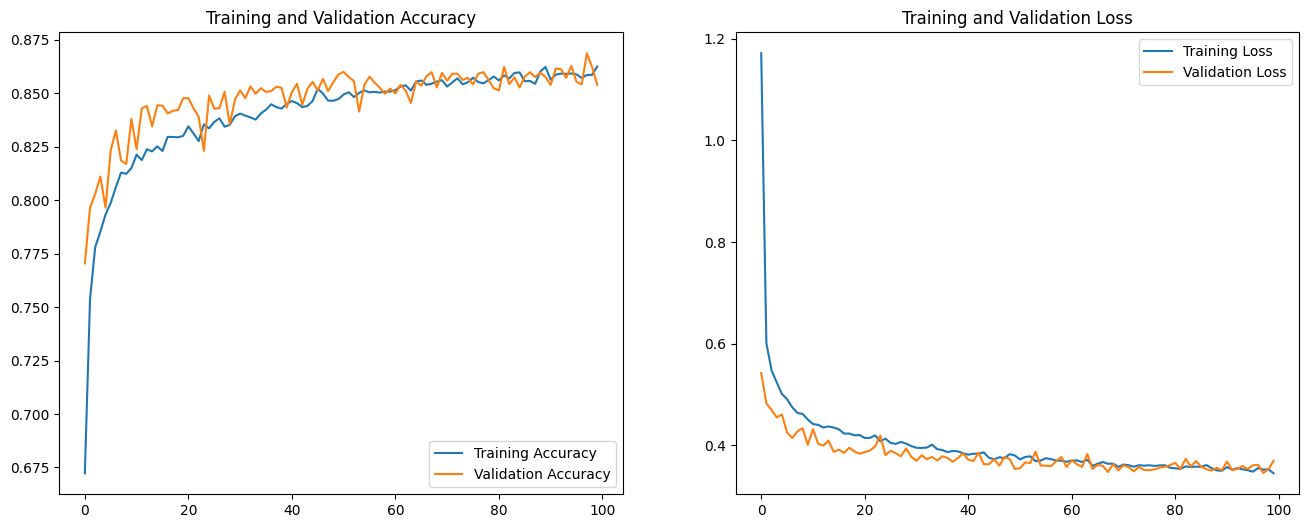

In [10]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 16s 38ms/step - loss: 0.9784 - accuracy: 0.6673 - val_loss: 0.5714 - val_accuracy: 0.7529
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6266 - accuracy: 0.7348 - val_loss: 0.5278 - val_accuracy: 0.7794
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5842 - accuracy: 0.7526 - val_loss: 0.5038 - val_accuracy: 0.7869
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5479 - accuracy: 0.7721 - val_loss: 0.5000 - val_accuracy: 0.7890
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5303 - accuracy: 0.7779 - val_loss: 0.4823 - val_accuracy: 0.7930
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5169 - accuracy: 0.7860 - v

360/360 [==============================] - 13s 37ms/step - loss: 0.3928 - accuracy: 0.8406 - val_loss: 0.3879 - val_accuracy: 0.8454
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3959 - accuracy: 0.8405 - val_loss: 0.3897 - val_accuracy: 0.8473
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3872 - accuracy: 0.8432 - val_loss: 0.3900 - val_accuracy: 0.8451
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3853 - accuracy: 0.8445 - val_loss: 0.4076 - val_accuracy: 0.8324
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3869 - accuracy: 0.8429 - val_loss: 0.3966 - val_accuracy: 0.8461
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3859 - accuracy: 0.8446 - val_loss: 0.3960 - val_accuracy: 0.8409
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3865 - accuracy: 0.8471 - val_loss: 0.3877 - val_accuracy

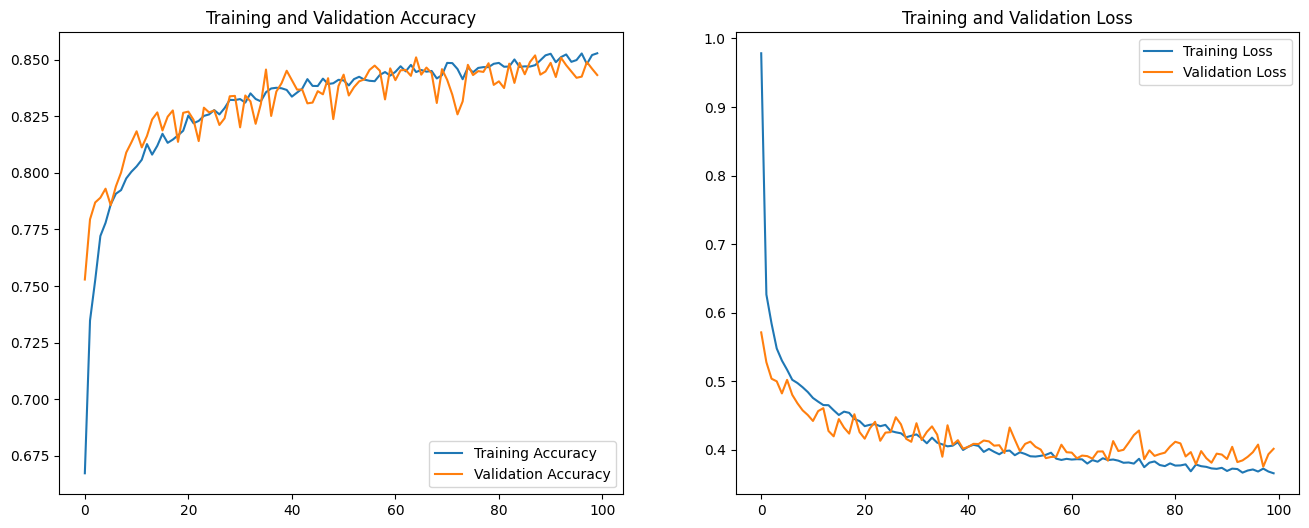

In [12]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 17s 39ms/step - loss: 1.2566 - accuracy: 0.6431 - val_loss: 0.5982 - val_accuracy: 0.7515
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6625 - accuracy: 0.7246 - val_loss: 0.5413 - val_accuracy: 0.7758
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6068 - accuracy: 0.7472 - val_loss: 0.5075 - val_accuracy: 0.7895
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5762 - accuracy: 0.7569 - val_loss: 0.5177 - val_accuracy: 0.7770
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5523 - accuracy: 0.7742 - val_loss: 0.4695 - val_accuracy: 0.8062
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5400 - accuracy: 0.7783 - val_loss: 0.4686 - va

360/360 [==============================] - 13s 37ms/step - loss: 0.4192 - accuracy: 0.8307 - val_loss: 0.3872 - val_accuracy: 0.8460
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4182 - accuracy: 0.8292 - val_loss: 0.3926 - val_accuracy: 0.8435
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4203 - accuracy: 0.8297 - val_loss: 0.4227 - val_accuracy: 0.8307
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4142 - accuracy: 0.8323 - val_loss: 0.3909 - val_accuracy: 0.8430
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4218 - accuracy: 0.8326 - val_loss: 0.3888 - val_accuracy: 0.8477
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4143 - accuracy: 0.8341 - val_loss: 0.3833 - val_accuracy: 0.8499
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4151 - accuracy: 0.8328 - val_loss: 0.3877 - val_accuracy

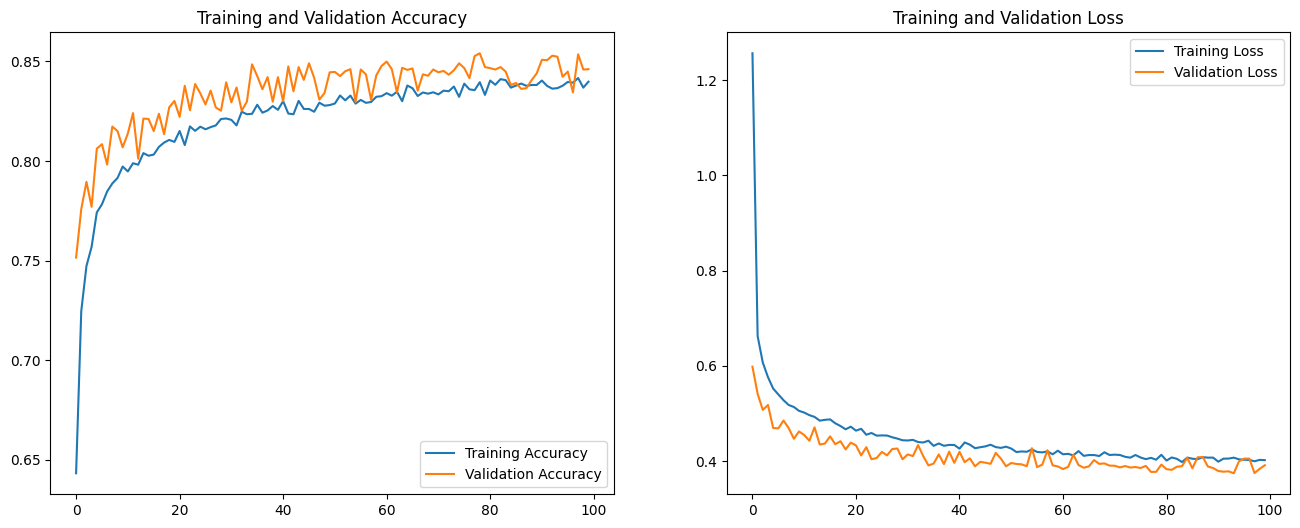

In [13]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [14]:
pd.DataFrame(res_hls_pre).to_csv("vgg16_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("vgg16_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("vgg16_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("vgg16_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("vgg16_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("vgg16_nontrainable/res_ycrcb_nonpre.csv", index=False)